<a href="https://colab.research.google.com/github/LukasEder1/StationarityPrediction/blob/main/LLMS/BART_MNLI__Zero_Shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/LukasEder1/StationarityPrediction.git
!pip install datasets

Cloning into 'StationarityPrediction'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 52 (delta 22), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (52/52), 1.19 MiB | 3.56 MiB/s, done.
Resolving deltas: 100% (22/22), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd

df = pd.read_csv("/content/StationarityPrediction/LLMS/clean_dataset_combined.csv", delimiter=";")

In [3]:
# Getting Rid of -1 Predicitions:
mask = df['final_vote'] == -1

# select all rows except the ones that contain 'Coca Cola'
df = df[~mask]

df = df.copy()
# binarize the classification variable
df.loc[:, "final_vote"]= df["final_vote"].apply(lambda x: int(x != 0))

In [4]:
df

,text,vote1,vote2,vote3,final_vote
0,I got 30 mins to decide if i want to participa...,4,4,-1,1
1,i hate feeling like im forcing someone to talk...,0,0,-1,0
2,Perry spam below I wanted to see old tweets in...,0,0,-1,0
3,i feel like i could pull off a blonde wig,0,0,-1,0
4,It's early but I want some Cajun rice,4,4,-1,1
...,...,...,...,...,...
2989,I need to take a picture of myself in a mirror,2,0,2,1
2990,Verizon and Xfinity goin be prorating this nex...,0,10,10,1
2991,I'm over here obsessing over a $300 lamp,7,3,3,1
2993,Instead of 18 minutes it took me an hour to ge...,6,5,5,1


In [5]:
from sklearn.model_selection import train_test_split

data = df[["text", "final_vote"]].rename(columns={"final_vote": "label"})

# Split Data into 80% train, 10% validation, 10% test
train_data, test_val_data = train_test_split(data, test_size=0.2, random_state=12, stratify=data['label'])

test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=12, stratify=test_val_data['label'])

print(f"Training set: {len(train_data)}")
print(f"Testing set: {len(test_data)}")
print(f"Validation set: {len(val_data)}")

Training set: 2304
Testing set: 288
Validation set: 289


In [6]:
from tqdm.auto import tqdm
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
txts = test_data.text.values

In [13]:
candidate_labels = ["stationary", "time-sensitive"]
import numpy as np

top_pred = []
outputs = []
for example in tqdm(txts):
    out = classifier(example, candidate_labels, multi_label=False)
    outputs.append(out)
    top_pred.append(out["labels"][0])

  0%|          | 0/288 [00:00<?, ?it/s]

In [14]:
def encode_labels(labels):
  return [int(label == "time-sensitive") for label in labels]

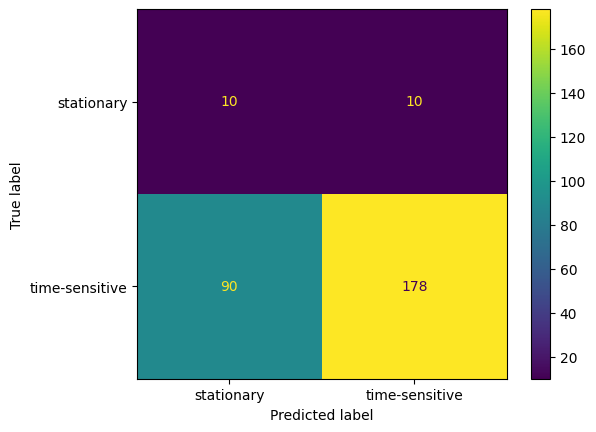

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = ["stationary",  "time-sensitive"]

y_preds = encode_labels(top_pred)
y_valid = test_data["label"].values

cm = confusion_matrix(y_preds, y_valid, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_preds)

0.6527777777777778

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_preds)

0.6527777777777778